In [1]:
# import libraries 
import pandas as pd
import matplotlib.pyplot as plt
import os 
import math
import sys
from pathlib import Path
import seaborn as sns

# Add 'src' to the system path
sys.path.append(str(Path().resolve() / 'src'))
from src.data.process_data import *
from src.data.clean_data import *

IMPORTANT: these scripts/functions assume you have the following files in the data/raw directory:
- From the CMU dataset: 
    - movie.metadata.tsv
    - plot_summaries.txt
- From the TMDB dataset: 
    - TMDB_movie_dataset_v11.csv

AND have data/processed folder created

Note: download CMU dataset here: https://www.cs.cmu.edu/~ark/personas/data/MovieSummaries.tar.gz
and TMDB dataset here (Download button): https://www.kaggle.com/datasets/asaniczka/tmdb-movies-dataset-2023-930k-movies

In [85]:
# from raw files, creates clean datafiles
%run src/data/clean_data.py

sep ,
headers []
original df shape (1127777, 24)
after status (1102507, 24)
after release date (760210, 24)
after release year (760210, 25)
after duplicates (745861, 25)
after numeric columns (745860, 25)
after select columns (745860, 13)
sep 	
headers ['wikipedia_movie_id', 'freebase_ID', 'title', 'release_year', 'revenue', 'runtime', 'languages', 'countries', 'genres']
original df shape (81740, 9)
after status (81740, 9)
after release date (81740, 9)
after release year (44006, 9)
after duplicates (43915, 9)
after numeric columns (43915, 9)
after select columns (43915, 5)


In [2]:
# from clean data files, creates a dataframe with CMU + plots & TMDB movies 
%run src/data/process_data.py
df_combined = create_cmu_tmdb_dataset('data/processed/movies.csv','data/processed/plot_summaries.csv', 'data/processed/TMDB_clean.csv', 'right')

In [3]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1156483 entries, 0 to 745859
Data columns (total 15 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   release_year          1156483 non-null  int64  
 1   summary               363880 non-null   object 
 2   release_date          1156483 non-null  object 
 3   budget                1156483 non-null  int64  
 4   original_language     1156483 non-null  object 
 5   overview              968191 non-null   object 
 6   genres                1156483 non-null  object 
 7   production_companies  1156483 non-null  object 
 8   production_countries  1156483 non-null  object 
 9   spoken_languages      1156483 non-null  object 
 10  keywords              1156483 non-null  object 
 11  runtime               430243 non-null   float64
 12  title                 430240 non-null   object 
 13  revenue               430243 non-null   float64
 14  dvd_era               1156483 non-null  

In [4]:
df_combined.head()

,release_year,summary,release_date,budget,original_language,overview,genres,production_companies,production_countries,spoken_languages,keywords,runtime,title,revenue,dvd_era
0,2010,"Former dream architect Dominick ""Dom"" Cobb a...",2010-07-15,160000000,en,"Cobb, a skilled thief who commits corporate es...","[Action, Science Fiction, Adventure]","[Legendary Pictures, Syncopy, Warner Bros. Pic...","[United Kingdom, United States of America]","[English, French, Japanese, Swahili]","[rescue, mission, dream, airplane, paris, fran...",296.0,InceptionInception,1.651066e+09,post
1,2014,NaN,2014-11-05,165000000,en,The adventures of a group of explorers who mak...,"[Adventure, Drama, Science Fiction]","[Legendary Pictures, Syncopy, Lynda Obst Produ...","[United Kingdom, United States of America]",[English],"[rescue, future, spacecraft, race against time...",NaN,NaN,NaN,post
2,2008,"In Gotham City, the Joker and his accomplices...",2008-07-16,185000000,en,Batman raises the stakes in his war on crime. ...,"[Drama, Action, Crime, Thriller]","[DC Comics, Legendary Pictures, Syncopy, Isobe...","[United Kingdom, United States of America]","[English, Mandarin]","[joker, sadism, chaos, secret identity, crime ...",305.0,The Dark KnightThe Dark Knight,2.009117e+09,post
3,2009,"By 2154, humans have severely depleted Earth'...",2009-12-15,237000000,en,"In the 22nd century, a paraplegic Marine is di...","[Action, Adventure, Fantasy, Science Fiction]","[Dune Entertainment, Lightstorm Entertainment,...","[United States of America, United Kingdom]","[English, Spanish]","[future, society, culture clash, space travel,...",340.0,AvatarAvatar,5.705981e+09,post
4,2012,"The Asgardian Loki encounters the Other, the ...",2012-04-25,220000000,en,When an unexpected enemy emerges and threatens...,"[Science Fiction, Action, Adventure]",[Marvel Studios],[United States of America],"[English, Hindi, Russian]","[new york city, superhero, shield, based on co...",280.0,The AvengersThe Avengers,3.030573e+09,post


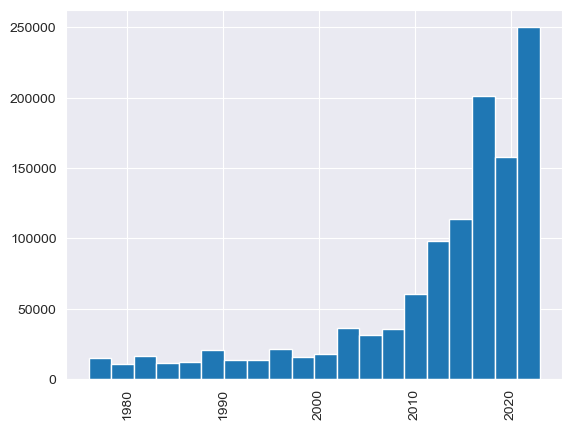

In [23]:
plt.hist(df_combined['release_year'], bins=20)
plt.xticks(rotation=90)
plt.show()

In [5]:
def top_proportions_per_era(df, column, k, islist=False):
    # get total number movies grouped by era and column 
    if islist:
        counts = df.explode(column).groupby(['dvd_era', column]).size().reset_index(name='count')
    else: 
        counts = df.groupby(['dvd_era', column]).size().reset_index(name='count')
    
    # get proportion 
    total_counts = counts.groupby('dvd_era')['count'].transform('sum')
    counts['proportion'] = counts['count'] / total_counts
    
    # get top-k for each era
    top_k = counts.sort_values(by=['proportion'], ascending=[False]).groupby('dvd_era').head(k)
    category_order = ['pre', 'during', 'post']
    top_k['dvd_era'] = pd.Categorical(top_k['dvd_era'], categories=category_order, ordered=True)
    
    return top_k

In [6]:
import colorcet as cc

def plot_top_proportions_per_era(top_k_df, column, k):
    pivot_data = top_k_df.pivot_table(index='dvd_era', columns=column, values='proportion', aggfunc='sum', observed=True).fillna(0)
    palette = sns.color_palette(cc.glasbey, n_colors=len(pivot_data.columns))

    # use stacked bar plot
    pivot_data.plot(kind='bar', stacked=True, figsize=(8, 6),color=palette)
    
    plt.title('Proportions of top ' + str(k) + " " + column + ' by DVD Era', fontsize=16)
    plt.xlabel('DVD Era', fontsize=14)
    plt.ylabel('Proportion', fontsize=14)
    plt.legend(title=column, bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()

# Production companies

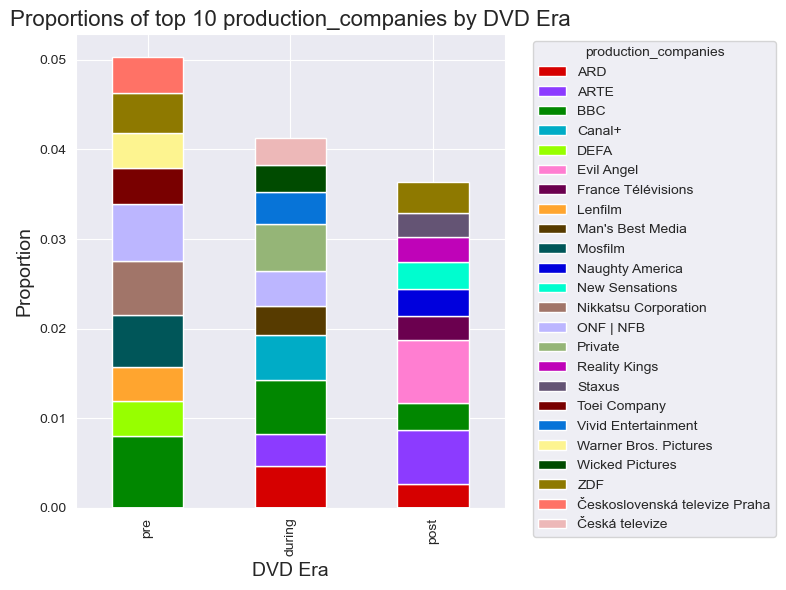

In [7]:
top_10_prod_companies = top_proportions_per_era(df_combined, 'production_companies', 10, True)
plot_top_proportions_per_era(top_10_prod_companies, 'production_companies', 10)

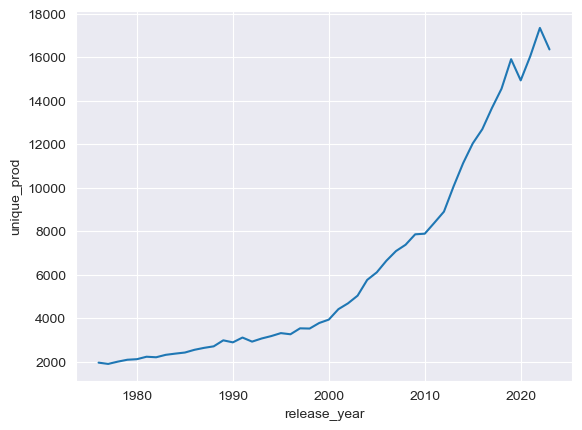

In [8]:
num_production_companies_per_year = df_combined.explode('production_companies').groupby('release_year')['production_companies'].nunique().reset_index(name='unique_prod')
sns.lineplot(data=num_production_companies_per_year, x='release_year', y='unique_prod')
plt.show()

# Countries

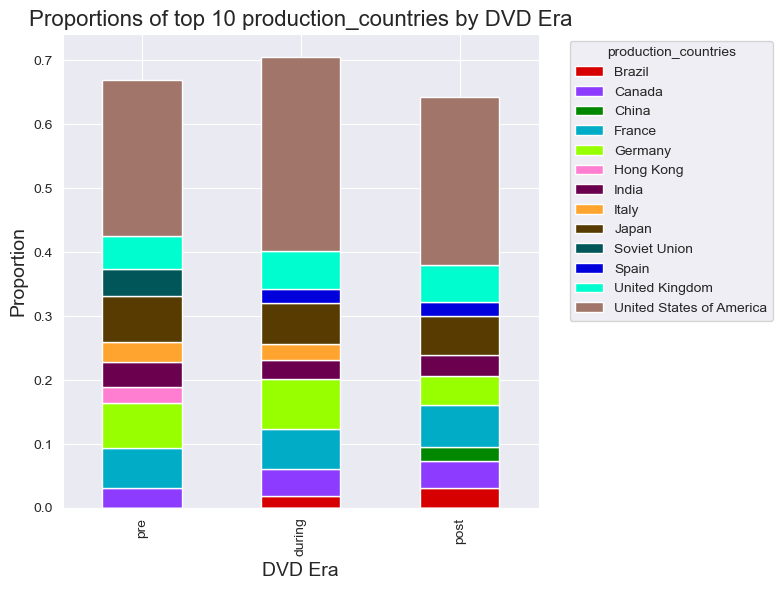

In [9]:
top_10_prod_countries = top_proportions_per_era(df_combined, 'production_countries', 10, True)
plot_top_proportions_per_era(top_10_prod_countries, 'production_countries', 10)

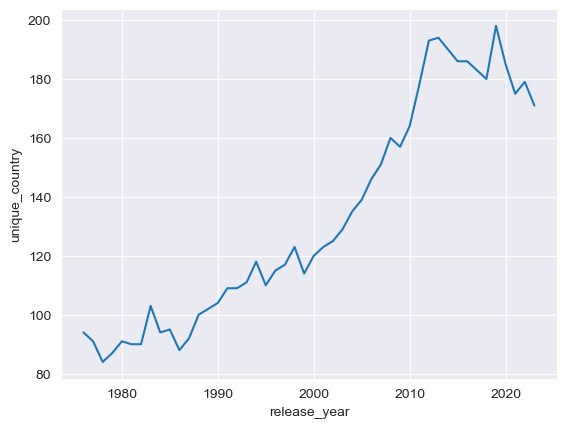

In [10]:
num_production_countries_per_year = df_combined.explode('production_countries').groupby('release_year')['production_countries'].nunique().reset_index(name='unique_country')
sns.lineplot(data=num_production_countries_per_year, x='release_year', y='unique_country')
plt.show()

# Original language

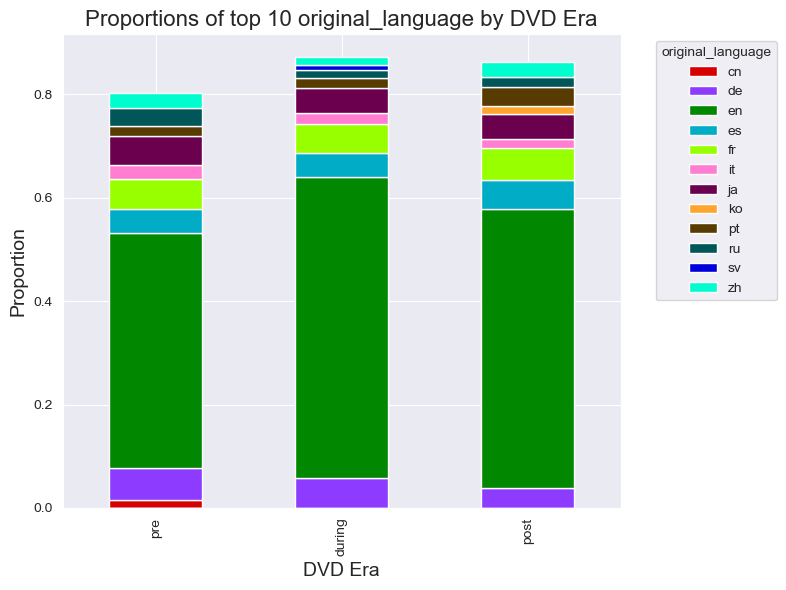

In [11]:
top_10_og_lang = top_proportions_per_era(df_combined, 'original_language', 10)
plot_top_proportions_per_era(top_10_og_lang, 'original_language', 10)

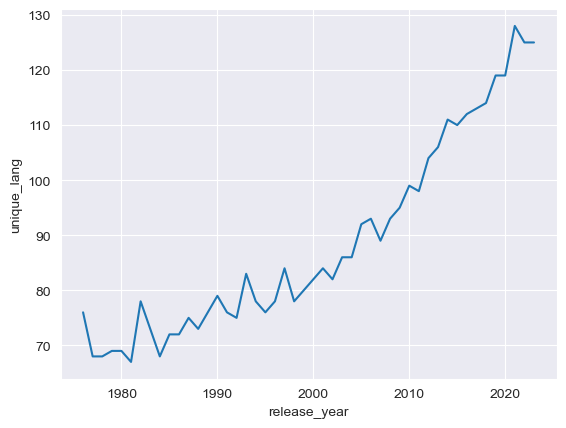

In [12]:
num_lang_per_year = df_combined.groupby('release_year')['original_language'].nunique().reset_index(name='unique_lang')
sns.lineplot(data=num_lang_per_year, x='release_year', y='unique_lang')
plt.show()

In [13]:
num_movies_per_year = df_combined.groupby('release_year').size().reset_index(name='num_movies')
num_movies_per_year.head()

,release_year,num_movies
0,1976,5098
1,1977,4894
2,1978,5274
3,1979,5412
4,1980,5367


In [14]:
num_lang_per_year['ratio'] = num_lang_per_year['unique_lang'] / num_movies_per_year['num_movies']
num_lang_per_year.head()

,release_year,unique_lang,ratio
0,1976,76,0.014908
1,1977,68,0.013895
2,1978,68,0.012893
3,1979,69,0.012749
4,1980,69,0.012856


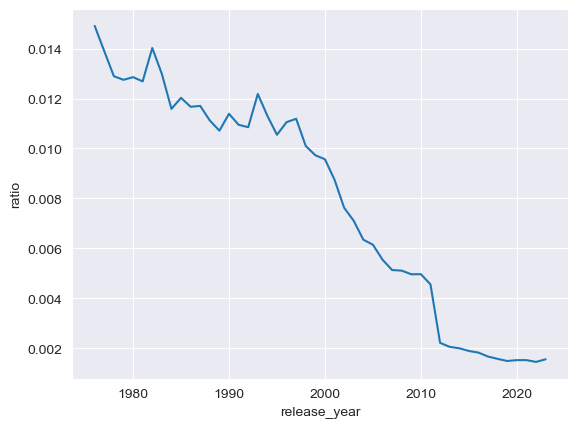

In [15]:
sns.lineplot(data=num_lang_per_year, x='release_year', y='ratio')
plt.show()

# genre


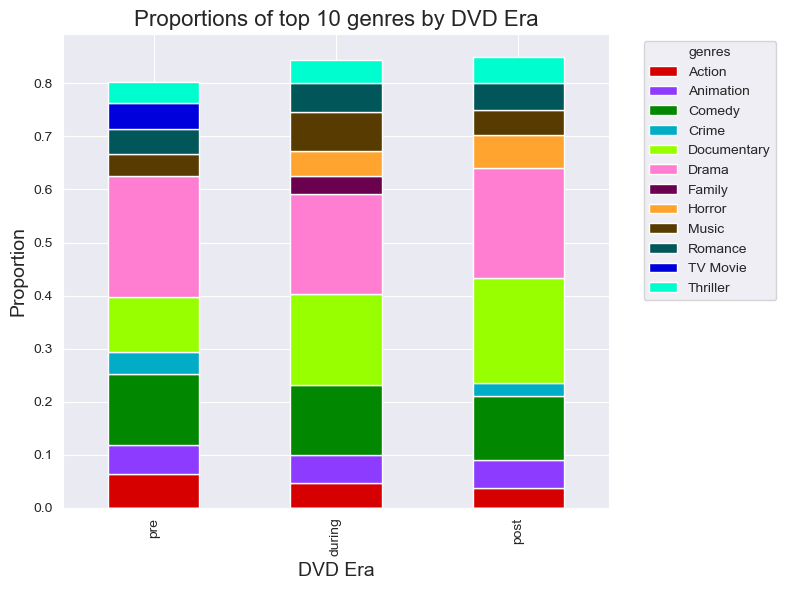

In [16]:
top_10_genre =top_proportions_per_era(df_combined, 'genres', 10, True)
plot_top_proportions_per_era(top_10_genre, 'genres', 10)

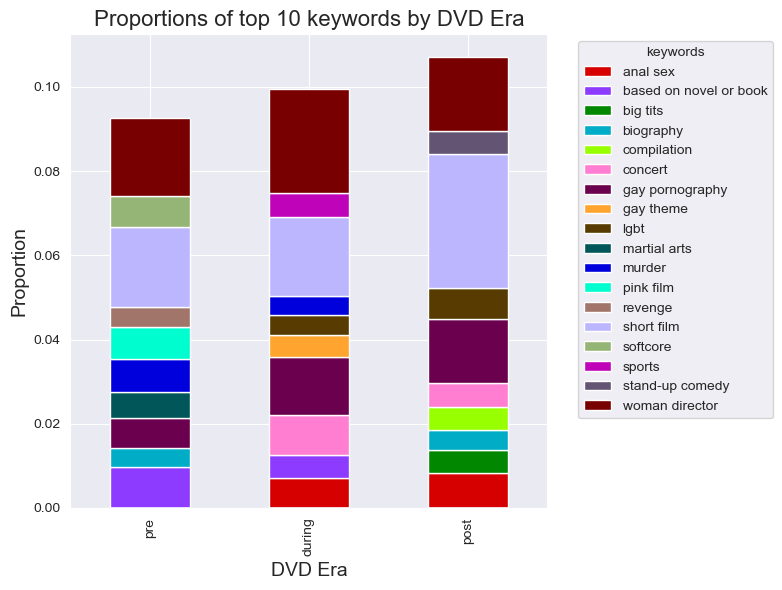

In [17]:
top_10_keyword =top_proportions_per_era(df_combined, 'keywords', 10, True)
plot_top_proportions_per_era(top_10_keyword, 'keywords', 10)

In [18]:
df_combined[df_combined['revenue']>0].groupby('dvd_era').agg(mean_rev=('revenue', 'mean'))

,mean_rev
dvd_era,
during,1.107000e+08
post,5.644045e+07
pre,7.184131e+07


In [19]:
df_combined[df_combined['budget']>0].groupby('dvd_era').agg(mean_rev=('budget', 'mean'))

,mean_rev
dvd_era,
during,1.310243e+07
post,4.970444e+06
pre,1.131343e+07
